# Classification of cars models/make/year

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [2]:
import scipy.io as sio
from fastai import *
from fastai.vision import *

## Getting car data

Data set available from https://ai.stanford.edu/~jkrause/cars/car_dataset.html
Download full image zip from http://imagenet.stanford.edu/internal/car196/car_ims.tgz
and annotation file from http://imagenet.stanford.edu/internal/car196/cars_annos.mat
- Run the cell below to scale images to 224x244

In [36]:
def crop(image_path, coords, size,saved_location):
    """
    @param image_path: The path to the image to edit
    @param coords: A tuple of x/y coordinates (x1, y1, x2, y2)
    @param saved_location: Path to save the cropped image
    """
    image_obj = Image.open(image_path)
    cropped_image = image_obj.crop(coords)
    cropped_image = cropped_image.resize(size)
    cropped_image.save(saved_location)

In [3]:
doc(ImageDataBunch.from_lists)

from_lists 
 from_lists ( path : PathOrStr , fnames : FilePathList , labels : StrList , valid_pct : int = 0.2 , test : str = None , kwargs )
 [source] 
 
 Show in docs

Function below extracts image path and labels from matlab file cars_annos.mat

In [4]:
def get_paths_and_labels(path,prefix_path):
    annos = sio.loadmat(os.path.join(path, 'cars_annos.mat'))
    class_names = [x[0] for x in annos["class_names"][0]]

    _, total_size = annos["annotations"].shape
    file_path_list = []
    label_list = []
    bbox_list = []
    print("total sample size is ", total_size)
    for i in range(total_size):
        file_name = annos["annotations"][:, i][0][0][0].split("/")[1]
        bbox_x1 = annos["annotations"][:, i][0][1][0]
        bbox_y1 = annos["annotations"][:, i][0][2][0]
        bbox_x2 = annos["annotations"][:, i][0][3][0]
        bbox_y2 = annos["annotations"][:, i][0][4][0]
        class_index = annos["annotations"][:, i][0][5][0][0]
#         print(f"{class_index}")
        class_name = class_names[class_index-1]
        is_test = annos["annotations"][:, i][0][6][0]
        if is_test:
            file_path_list.append(f"{prefix_path}//{file_name}")
            label_list.append(class_name)
            bbox_list.append((bbox_x1, bbox_y1, bbox_x2, bbox_y2))

    return file_path_list, label_list,bbox_list

In [ ]:
## CROP IMAGES ONLY ONCE
def crop_images()
    data_path = "/home/jupyter/data/"
    src_path = f"{data_path}/car_ims/"
    dst_path = f"{data_path}/cropped_car_ims/"
    path_list,label_list,bbox_list = get_paths_and_labels(data_path,src_path)
    for path, label, bbox in zip(file_paths, labels, bbox_list):
        count += 1
        print(f"  {path} {label} {bbox}")
        image_path = f"{src_path}\\{path}"
        cropped_image_path = f"{dst_path}\\{path}"
        crop(image_path, bbox, cropped_image_path)

In [5]:
data_path = "/home/jupyter/data/"
train_path = f"{data_path}/cropped_car_ims/"
path_list,label_list,bbox_list = get_paths_and_labels(data_path,train_path)
print(len(path_list))
print(len(label_list))


total sample size is  16185
8041
8041


In [6]:
data = ImageDataBunch.from_lists(train_path,path_list,label_list,ds_tfms=get_transforms(),size=224)
#data.normalize(imagenet_stats)

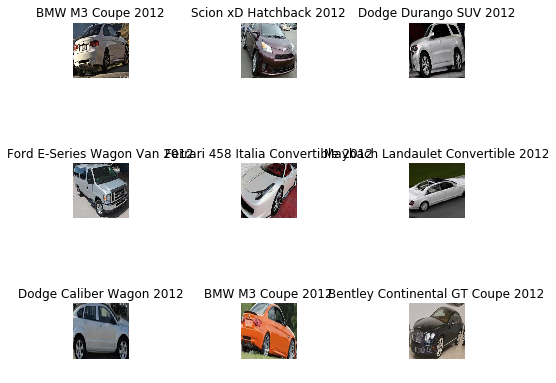

In [7]:
data.show_batch(rows=3, figsize=(7,6))

In [8]:
print(data.classes)
len(data.classes),data.c

['AM General Hummer SUV 2000', 'Acura RL Sedan 2012', 'Acura TL Sedan 2012', 'Acura TL Type-S 2008', 'Acura TSX Sedan 2012', 'Acura Integra Type R 2001', 'Acura ZDX Hatchback 2012', 'Aston Martin V8 Vantage Convertible 2012', 'Aston Martin V8 Vantage Coupe 2012', 'Aston Martin Virage Convertible 2012', 'Aston Martin Virage Coupe 2012', 'Audi RS 4 Convertible 2008', 'Audi A5 Coupe 2012', 'Audi TTS Coupe 2012', 'Audi R8 Coupe 2012', 'Audi V8 Sedan 1994', 'Audi 100 Sedan 1994', 'Audi 100 Wagon 1994', 'Audi TT Hatchback 2011', 'Audi S6 Sedan 2011', 'Audi S5 Convertible 2012', 'Audi S5 Coupe 2012', 'Audi S4 Sedan 2012', 'Audi S4 Sedan 2007', 'Audi TT RS Coupe 2012', 'BMW ActiveHybrid 5 Sedan 2012', 'BMW 1 Series Convertible 2012', 'BMW 1 Series Coupe 2012', 'BMW 3 Series Sedan 2012', 'BMW 3 Series Wagon 2012', 'BMW 6 Series Convertible 2007', 'BMW X5 SUV 2007', 'BMW X6 SUV 2012', 'BMW M3 Coupe 2012', 'BMW M5 Sedan 2010', 'BMW M6 Convertible 2010', 'BMW X3 SUV 2012', 'BMW Z4 Convertible 2012

(196, 196)

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 ouptuts).

We will train for 5 epochs (5 cycles through all our data).

In [9]:
learn = ConvLearner(data, models.resnet34, metrics=error_rate)

In [10]:
learn.fit_one_cycle(4)

Total time: 01:08
epoch  train loss  valid loss  error_rate
1      4.991842    4.009378    0.856075    (00:18)
2      3.388085    2.586498    0.611215    (00:16)
3      2.285568    2.005249    0.489097    (00:16)
4      1.769534    1.909633    0.466667    (00:16)



In [11]:
learn.save('stage-1')

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [13]:
interp = ClassificationInterpretation.from_learner(learn)

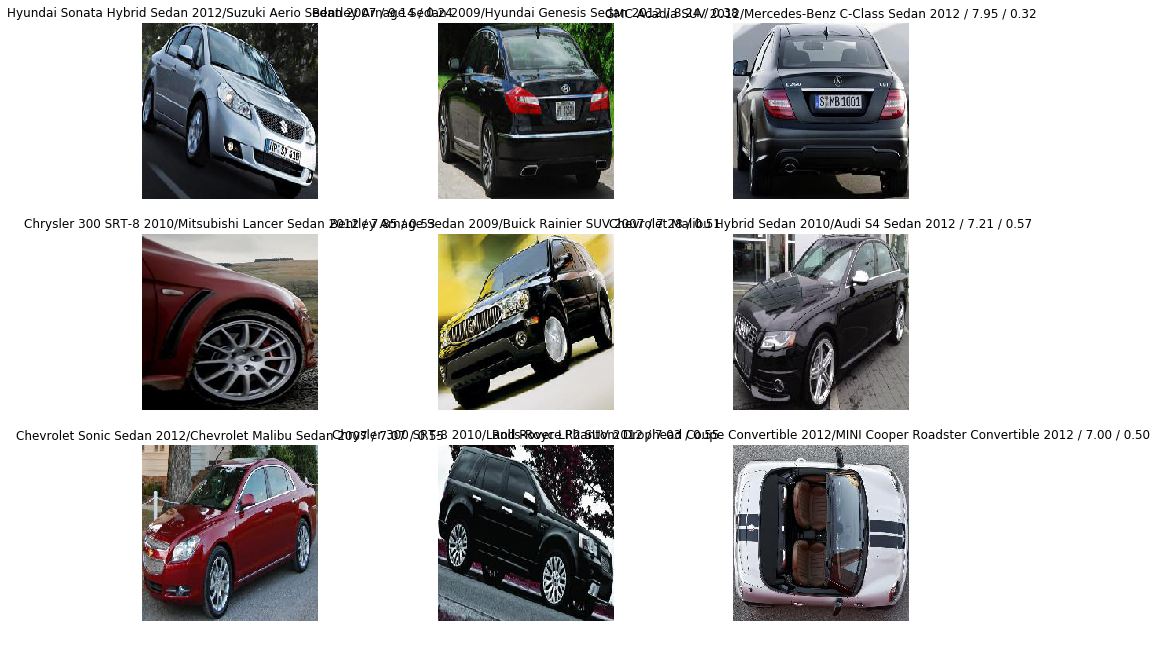

In [14]:
interp.plot_top_losses(9, figsize=(15,11))

In [48]:
doc(interp.plot_top_losses)

plot_top_losses 
 plot_top_losses ( k , largest = True , figsize = (12, 12) ) 
 
 Show images in top_losses along with their loss, label, and prediction. [source] 
 Show in docs

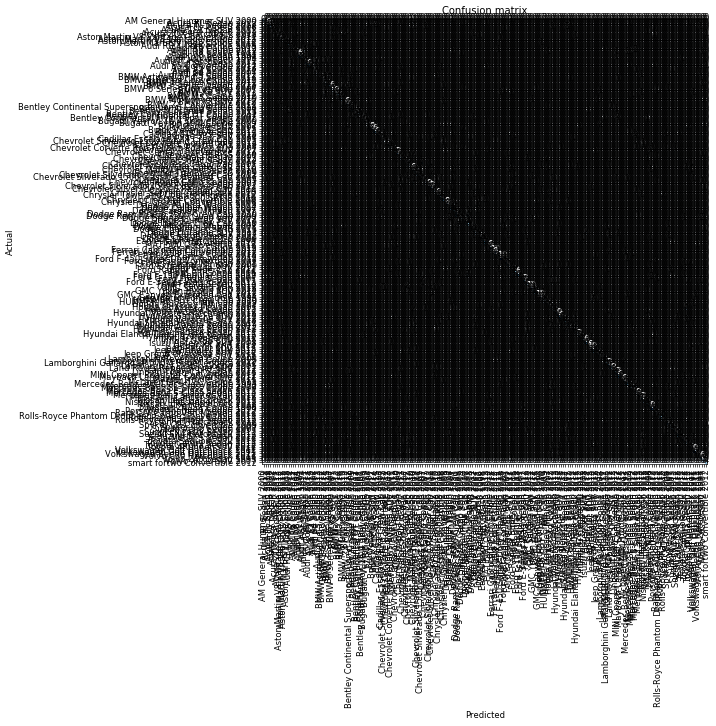

In [49]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [15]:
interp.most_confused(min_val=2)

[('BMW M6 Convertible 2010', 'BMW 6 Series Convertible 2007', 5),
 ('Chevrolet Express Van 2007', 'GMC Savana Van 2012', 5),
 ('Aston Martin V8 Vantage Coupe 2012', 'Ferrari FF Coupe 2012', 4),
 ('Audi TTS Coupe 2012', 'Audi TT Hatchback 2011', 4),
 ('Audi TT Hatchback 2011', 'Audi TT RS Coupe 2012', 4),
 ('Chevrolet Express Cargo Van 2007', 'GMC Savana Van 2012', 4),
 ('Ferrari 458 Italia Convertible 2012', 'Ferrari 458 Italia Coupe 2012', 4),
 ('Audi RS 4 Convertible 2008', 'Audi S4 Sedan 2007', 3),
 ('Audi 100 Sedan 1994', 'Audi V8 Sedan 1994', 3),
 ('Bentley Arnage Sedan 2009', 'Bentley Mulsanne Sedan 2011', 3),
 ('Chevrolet Malibu Sedan 2007', 'Chevrolet Malibu Hybrid Sedan 2010', 3),
 ('Chevrolet Silverado 1500 Extended Cab 2012',
  'Chevrolet Silverado 1500 Hybrid Crew Cab 2012',
  3),
 ('Dodge Caliber Wagon 2007', 'Dodge Caliber Wagon 2012', 3),
 ('Ford F-150 Regular Cab 2007', 'Ford Ranger SuperCab 2011', 3),
 ('Scion xD Hatchback 2012', 'Suzuki SX4 Hatchback 2012', 3),
 ('Spy

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [51]:
learn.unfreeze()

In [52]:
learn.fit_one_cycle(1)

Total time: 00:45
epoch  train loss  valid loss  error_rate
1      3.031895    2.256547    0.574734    (00:45)



In [16]:
learn.load('stage-1')

In [17]:
learn.lr_find()

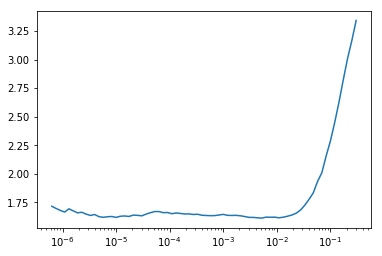

In [18]:
learn.recorder.plot()

In [19]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-2))

Total time: 00:43
epoch  train loss  valid loss  error_rate
1      2.261739    2.007966    0.511526    (00:21)
2      1.409297    1.207403    0.328349    (00:21)



In [20]:
learn.save('stage-2')

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. Later in the course you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here.

In [23]:
data = ImageDataBunch.from_lists(train_path,path_list,label_list,ds_tfms=get_transforms(),size=224,bs=48)
data.normalize(imagenet_stats)

In [24]:
learn = ConvLearner(data, models.resnet50, metrics=error_rate)

In [25]:
learn.fit_one_cycle(5)

Total time: 02:30
epoch  train loss  valid loss  error_rate
1      4.590001    3.538155    0.777368    (00:33)
2      2.914700    2.039641    0.504305    (00:29)
3      1.745406    1.373419    0.354859    (00:29)
4      1.086804    1.126082    0.285978    (00:29)
5      0.830888    1.074393    0.273678    (00:29)



In [26]:
learn.save('stage-1-50')

It's astonishing that it's possible to recognize pet breeds so accurately! Let's see if full fine-tuning helps:

In [27]:
learn.unfreeze()
learn.fit_one_cycle(1, max_lr=slice(1e-6,1e-3))

Total time: 00:38
epoch  train loss  valid loss  error_rate
1      0.789576    0.970822    0.266913    (00:38)



In this case it doesn't, so let's go back to our previous model.

In [28]:
learn.save('stage-2-50')
learn.load('stage-2-50')

In [29]:
interp = ClassificationInterpretation.from_learner(learn)

In [30]:
interp.most_confused(min_val=2)

[('BMW 6 Series Convertible 2007', 'BMW M6 Convertible 2010', 7),
 ('Aston Martin V8 Vantage Convertible 2012',
  'Aston Martin V8 Vantage Coupe 2012',
  4),
 ('Aston Martin Virage Convertible 2012',
  'Aston Martin V8 Vantage Convertible 2012',
  3),
 ('Aston Martin Virage Convertible 2012',
  'Aston Martin V8 Vantage Coupe 2012',
  3),
 ('Audi A5 Coupe 2012', 'Audi S5 Coupe 2012', 3),
 ('Audi TTS Coupe 2012', 'Audi TT Hatchback 2011', 3),
 ('Audi 100 Sedan 1994', 'Audi V8 Sedan 1994', 3),
 ('Audi TT Hatchback 2011', 'Audi TT RS Coupe 2012', 3),
 ('Audi S6 Sedan 2011', 'Audi S5 Coupe 2012', 3),
 ('BMW M3 Coupe 2012', 'BMW M5 Sedan 2010', 3),
 ('BMW M5 Sedan 2010', 'Suzuki Kizashi Sedan 2012', 3),
 ('Chevrolet Silverado 1500 Hybrid Crew Cab 2012',
  'Chevrolet Silverado 1500 Regular Cab 2012',
  3),
 ('Chevrolet Express Cargo Van 2007', 'GMC Savana Van 2012', 3),
 ('Ferrari 458 Italia Convertible 2012', 'Ferrari 458 Italia Coupe 2012', 3)]